In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
target = np.loadtxt('/Users/domitillecoulomb/Documents/DATA_SCIENCE/Semester2/Str_Data/Project/Project_Data/ncicancer_targets_ex0.txt')
target.shape

(2305, 59)

In [3]:
hf = np.loadtxt('/Users/domitillecoulomb/Documents/DATA_SCIENCE/Semester2/Str_Data/Project/Project_Data/ncicancer_kernel_hf_ex0.txt')

## Preprocessing et Formattage des données de sortie

> On the github page of the project, it is written: "We notice that the activity score is computed according -10*log(GI50). We still need binary value as the activity outcome for classification task. According to NCBI, a molecule is 'active' if the activity score is over(**=) 60 and 'inactive' otherwise."


In [17]:
y_label = target.copy()
y_label[y_label < 60] = -1
y_label[y_label >= 60] = 1

** Visulisation des données: Repartition de la bioactivité moléculaire **

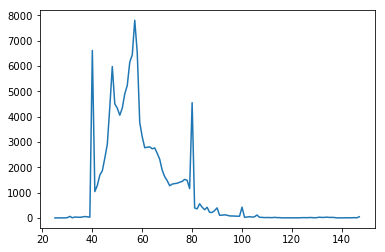

In [55]:
y_=np.empty(1)
for i in np.unique(target):
    y_ = np.append(y_,len(target[target == float(i)]))
y_= y_[1:]
plt.plot(np.unique(target), y_)

> On observe 3 pics de bioactivité modélculaire: 40, 60, 80. On en fait l'interprétation suivante (en accord avec les analyses de l'article):

> le pic à 40 peut être vu comme la mesure représentant une inactivité

> le pic à 80 peut être vu comme la mesure représentant une activité

> il y a des variations autour de ces données, avec une limite à 60. Cette limite est discutable. C'est celle utilisé dans l'article, mais on pourrait imaginer tester une autre limite d'activité.

** Justification de la limite à 60: Limite maximum pour que chaque molécule soit active sur un type de cellules, au moins**

In [54]:
np.min(np.max(target, axis=1))

60.0

## Markov Network

The first step is to construct from the target data (cell-lines bioactivity) a correlation matrix between the pairs of cell lines. Then, we can extract the Markov network from the matrix by favoring high-valued pairs (two methods will be explained afterwards)

In [19]:
cov = np.cov(np.transpose(target)) # covariance matrix
pres = np.linalg.inv(cov) # precision matrix

### 2.1. Maximum weight spanning tree

In the paper, the maximum spanning tree is computed from additional data. Since we don't directly have access to this data, we tried first to build this tree by using the covariance matrix only (advise from Florence D'Alché Buc).

Using more additional data could be a way of improvement

/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be

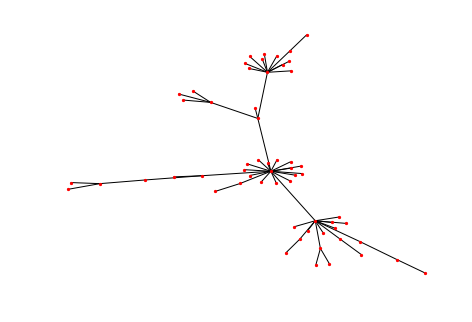

In [21]:
import networkx as nx
from spanning_tree import maximum_spanning_tree
A = cov.copy()
G= nx.from_numpy_matrix(A)
mst = maximum_spanning_tree(G)
nx.draw(mst, node_size=5)

**Computing the tree on the normalized coviarance: **
This method doesn't give the same results. Indeed, since the delta between all the data are very small, changing the path doesn't change the total weight sum a lot. That is why we end up with a very different graph. We will keep the first one (without normalization).

/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be

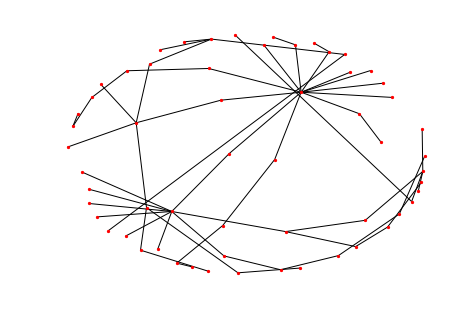

In [22]:
import networkx as nx
from spanning_tree import maximum_spanning_tree
from sklearn import preprocessing
A2 = cov.copy()
A2 = preprocessing.scale(A2)
G2 = nx.from_numpy_matrix(A2)
mst2 = maximum_spanning_tree(G2)
nx.draw(mst2, node_size=5)

**Understanding the Graph**

In [23]:
print(mst.number_of_nodes())
print(mst.order())
print(np.argsort(cov[0])[::-1])
test = np.argsort(cov[0])[::-1] [1]
print(mst.has_edge(0,test))

59
59
[ 0  3 24  7  4 30 20 15 18 19 45 56 31 22 12  9 32 55 25 21 10 17  2 41  1
 40 42 28 33  6 34 26 50 23 53 52 49 54 11 13 29 47 46 14 44 38  5 39 27 16
 35 48 51 58  8 37 43 36 57]
True


** Get edges for further analysis and use (mmCRF) **

In [277]:
mst.edges()

[(0, 3),
 (1, 24),
 (2, 24),
 (3, 32),
 (3, 4),
 (3, 7),
 (3, 12),
 (3, 47),
 (3, 24),
 (3, 18),
 (3, 20),
 (3, 56),
 (3, 52),
 (3, 29),
 (5, 24),
 (6, 31),
 (8, 25),
 (9, 30),
 (10, 31),
 (11, 31),
 (13, 15),
 (14, 33),
 (15, 20),
 (16, 31),
 (17, 24),
 (17, 34),
 (17, 38),
 (18, 35),
 (19, 24),
 (21, 24),
 (22, 24),
 (23, 24),
 (24, 54),
 (24, 41),
 (24, 42),
 (24, 44),
 (24, 45),
 (24, 43),
 (24, 55),
 (24, 28),
 (24, 30),
 (25, 57),
 (25, 26),
 (25, 30),
 (27, 31),
 (30, 31),
 (31, 49),
 (31, 50),
 (31, 46),
 (31, 40),
 (31, 51),
 (32, 36),
 (33, 34),
 (33, 39),
 (37, 45),
 (48, 50),
 (53, 56),
 (56, 58)]

### 2.2. Correlation thresholding

Take all edges that exceed fixed threshold. This approach typically generates a general non-tree graph

In [25]:
threshold = 135
A_thresh = cov.copy()
A_thresh[cov < threshold] = 0

/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be

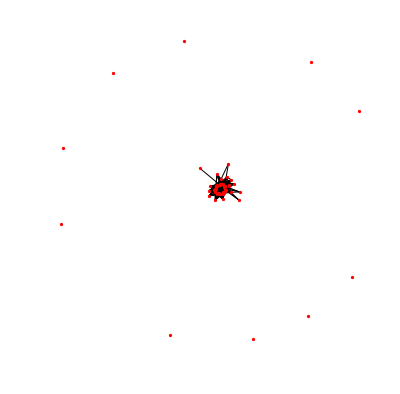

In [26]:
import networkx as nx
fig = plt.figure(figsize=(5,5))
G_thresh = nx.from_numpy_matrix(A_thresh)
rows, cols = np.where(A_thresh != 0)
edges = zip(rows.tolist(), cols.tolist())
G_thresh.add_edges_from(edges) 
nx.draw(G_thresh, node_size=5)

**Normalizing: ** Here, normalizing has a sense. Edges are determined by the thresholding, but when it is done we can normalize the weights. It will be the exact same edges, but normlized, which it better for vizualisation (see above). It makes sense to keep this method (with normalization).

/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be

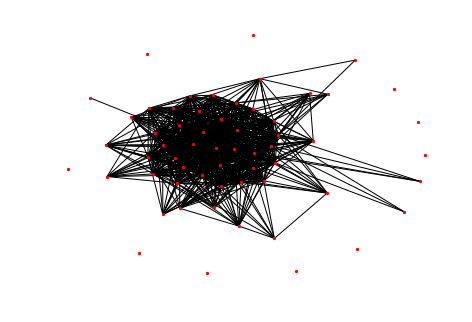

In [27]:
from sklearn import preprocessing
A_thresh = preprocessing.normalize(A_thresh)

G_thresh = nx.from_numpy_matrix(A_thresh)
rows, cols = np.where(A_thresh != 0)
edges = zip(rows.tolist(), cols.tolist())
G_thresh.add_edges_from(edges) 
nx.draw(G_thresh, node_size=5)